In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sphfile import SPHFile
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

import torch
import cv2
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data.dataset import Dataset
from IPython.core.debugger import set_trace

import os

import wave
from scipy import signal
from scipy.io import wavfile

import librosa
import resampy
import tensorflow as tf
import time
import random
import os
import click
import librosa.display

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
loader = None

cpu


In [4]:
def plot_spectrogram(spectrogram):
    librosa.display.specshow(np.transpose(spectrogram), cmap="plasma")
    plt.tight_layout()
    plt.savefig("spectrogram.png", bbox_inches=None, pad_inches=0)
    plt.close()

In [5]:
def getFeatures(wave_filepath, n_components):
    f, data = wavfile.read(wave_filepath)
    #data = data[:, 0]
    sp_f, sp_t, speech_Zxx = signal.stft(np.array(data), window='hamming', nperseg=1024, noverlap=0.75*1024)
    Sxx = np.log(np.absolute(speech_Zxx))
    plt.pcolormesh(sp_t, sp_f, Sxx)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    
    signal_y, sr = librosa.load(wave_filepath)
    mfcc = librosa.feature.mfcc(y=signal_y, sr=f, n_mfcc=n_components)
    
    return mfcc.T

In [6]:
def compute_spectrogram(audio, sr, n_comps):
    """
    Converts audio to an 80-band mel spectrogram.

    Args:
        audio: Raw audio data.
        sr:    Audio sample rate in Hz.

    Returns:
        80-band mel spectrogram, a numpy array of shape [frames, 80].
    """
    spectrogram = librosa.core.stft(audio, n_fft=2048, hop_length=400,
        win_length=1600)
    spectrogram = np.abs(spectrogram)
    spectrogram = np.dot(
        librosa.filters.mel(sr, 2048, n_mels=n_comps, fmin=0, fmax=8000),
        spectrogram)
    spectrogram = np.log(spectrogram*SCALING + 1e-2)
    return np.transpose(spectrogram)

In [7]:
def run_wavernn(model, spectrogram, output, n_comps):
    """
    Run inference using a frozen model.

    Args:
        model:       Frozen graph file, .pb format.
        spectrogram: 80-band mel spectrogram.
        output:      Output file.

    Returns:
        Output audio, 16 kHz sample rate.
    """
    # Pad the spectrograms (in the time dimension) before input.
    padding = 12
    spectrogram = np.pad(spectrogram, [[padding, padding], [0, 0]],
                         mode='constant')

    with tf.gfile.GFile(model, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    graph = tf.Graph()
    with graph.as_default():
        with tf.Session(graph=graph) as session:
            tf.import_graph_def(graph_def, name="")
            print("Generating samples...")
            start_time = time.time()
            audio = session.run(OUTPUT_NODE, feed_dict={
                INPUT_NODE: [spectrogram],
                TRAINING: False,
            })
            elapsed = time.time() - start_time
            generated_seconds = audio.size / SAMPLE_RATE

    print("Generated {:.2f}s in {:.2f}s ({:.3f}x realtime)."
        .format(generated_seconds, elapsed, generated_seconds / elapsed))
    return audio

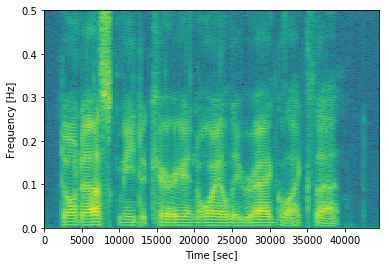

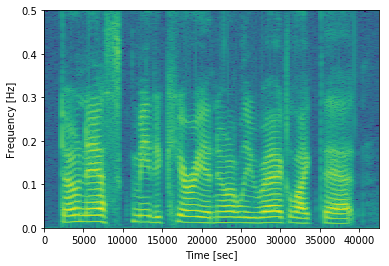

In [8]:
n_comps = 80

I = SPHFile('SA2I.WAV')
I.write_wav( 'Input.wav', 0, 8 )
I_mfcc = getFeatures('Input.wav', n_comps)

T = SPHFile('SA2T.WAV')
T.write_wav( 'Target.wav', 0, 8 )
T_mfcc = getFeatures('Target.wav', n_comps)

(120, 80)
(115, 80)


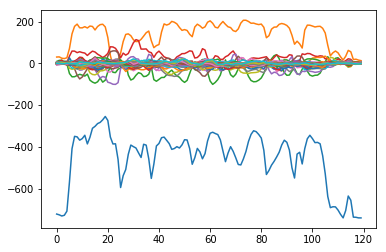

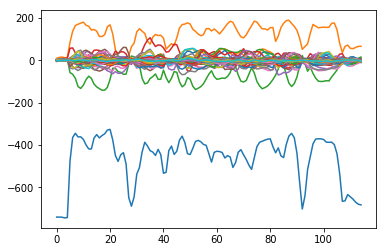

In [9]:
print(I_mfcc.shape)
print(T_mfcc.shape)
plt.figure(0)
_ = plt.plot(I_mfcc)

plt.figure(1)
_ = plt.plot(T_mfcc)

In [10]:
model = "models/frozen.pb"
output = "outputs/audio.wav"
SAMPLE_RATE = 16000
INPUT_NODE = "IteratorGetNext:1"
OUTPUT_NODE = "Inference/Model/MuLawExpanding/mul_1:0"
SCALING = 0.185
TRAINING = "training:0" 
n_comps = 80

data, sr = librosa.core.load("Input.wav", sr=SAMPLE_RATE, mono=True)
print("Length of audio: {:.2f}s".format(float(len(data))/sr))
in_spectrogram = compute_spectrogram(data, sr, n_comps).T
plot_spectrogram(in_spectrogram)

data, sr = librosa.core.load("Target.wav", sr=SAMPLE_RATE, mono=True)
print("Length of audio: {:.2f}s".format(float(len(data))/sr))
ta_spectrogram = compute_spectrogram(data, sr, n_comps).T
plot_spectrogram(ta_spectrogram)

print(ta_spectrogram.shape, type(ta_spectrogram))

# audio = run_wavernn(model, ta_spectrogram, output, n_comps)
# librosa.output.write_wav(output, audio, sr=SAMPLE_RATE)
# print("Wrote WAV file:", os.path.abspath(output))

Length of audio: 2.78s
Length of audio: 2.66s
(80, 107) <class 'numpy.ndarray'>


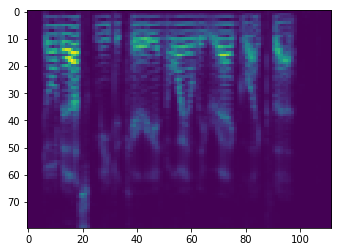

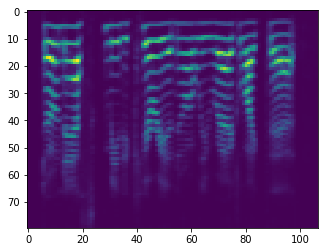

In [11]:
plt.figure(0)
plt.imshow(in_spectrogram)

plt.figure(1)
plt.imshow(ta_spectrogram)

In [12]:
class AudioSet(Dataset):
    def __init__(self, root_dir_I, root_dir_T, in_spectrogram, ta_spectrogram, transform=None):
        # I = input
        # T = target
        
        self.root_dir_I = root_dir_I
        self.root_dir_T = root_dir_T
        self.transform = transforms.Compose(transform)
        self.transform = transform
    def ToSpectogram(self,Wav):
        sample_rate, samples = Wav
        frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
        return frequencies, sample_rate, spectrogram

    def __getitem__(self, idx):
        I_name = self.root_dir_I
        T_name = self.root_dir_T
        I = wavfile.read(I_name)
        T = wavfile.read(T_name)
        frequenciesI, timesI, spectrogramI = self.ToSpectogram(I)
        frequenciesT, timesT, spectrogramT = self.ToSpectogram(T)
        spectrogramI = np.log10(spectrogramI)
        spectrogramT = np.log10(spectrogramT)

        spectrogramI = torch.from_numpy(in_spectrogram)
        spectrogramT = torch.from_numpy(ta_spectrogram)
#         print(in_spectrogram.shape[0], in_spectrogram.shape[1])
#         print(ta_spectrogram.shape[0], ta_spectrogram.shape[1])
    
        spectrogramI = spectrogramI[:,0: spectrogramT.shape[1]]
        print(spectrogramI.shape)
#         zeros = torch.zeros((in_spectrogram.shape[0]-ta_spectrogram.shape[0], in_spectrogram.shape[1])).double()
#         spectrogramT = torch.cat((spectrogramT, zeros), 0)
        
        print((spectrogramI.unsqueeze(0).shape), (spectrogramT.unsqueeze(0).shape))
        return spectrogramI.unsqueeze(0),spectrogramT.unsqueeze(0),frequenciesI, timesI,frequenciesT, timesT
        
    def __len__(self):
        return len(1)

In [13]:
Aud = AudioSet('Input.wav','Target.wav',in_spectrogram, ta_spectrogram, loader)
Aud = Aud[0]
frequenciesI = Aud[2]
timesI = Aud[3]
frequenciesT = Aud[4]
timesT = Aud[5]

Aud[0]
def minmax(I):
    return (I - I.min())/(I.max() - I.min())

torch.Size([80, 107])
torch.Size([1, 80, 107]) torch.Size([1, 80, 107])


In [14]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu




def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = Aud[0]
content_img = Aud[1]
style_img = style_img[0:1,:,0:189]
style_img = style_img.repeat(3,1,1)
content_img = content_img.repeat(3,1,1)
style_img = style_img.unsqueeze(0)
content_img = content_img.unsqueeze(0)
print(style_img.shape)
print(content_img.shape)

style_img = style_img.to(device, torch.float)
content_img = content_img.to(device, torch.float)
style_img = minmax(style_img)
content_img = minmax(content_img)
print(style_img)
# assert style_img.size() == content_img.size(), \
#     "we need to import style and content images of the same size"

torch.Size([1, 3, 80, 107])
torch.Size([1, 3, 80, 107])
tensor([[[[0.0019, 0.0051, 0.0076,  ..., 0.0069, 0.0042, 0.0080],
          [0.0032, 0.0047, 0.0056,  ..., 0.0028, 0.0026, 0.0063],
          [0.0017, 0.0034, 0.0041,  ..., 0.0024, 0.0022, 0.0052],
          ...,
          [0.0005, 0.0005, 0.0005,  ..., 0.0003, 0.0005, 0.0007],
          [0.0005, 0.0005, 0.0005,  ..., 0.0003, 0.0005, 0.0008],
          [0.0006, 0.0005, 0.0004,  ..., 0.0005, 0.0005, 0.0006]],

         [[0.0019, 0.0051, 0.0076,  ..., 0.0069, 0.0042, 0.0080],
          [0.0032, 0.0047, 0.0056,  ..., 0.0028, 0.0026, 0.0063],
          [0.0017, 0.0034, 0.0041,  ..., 0.0024, 0.0022, 0.0052],
          ...,
          [0.0005, 0.0005, 0.0005,  ..., 0.0003, 0.0005, 0.0007],
          [0.0005, 0.0005, 0.0005,  ..., 0.0003, 0.0005, 0.0008],
          [0.0006, 0.0005, 0.0004,  ..., 0.0005, 0.0005, 0.0006]],

         [[0.0019, 0.0051, 0.0076,  ..., 0.0069, 0.0042, 0.0080],
          [0.0032, 0.0047, 0.0056,  ..., 0.0028, 0.0

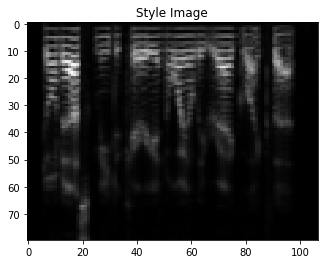

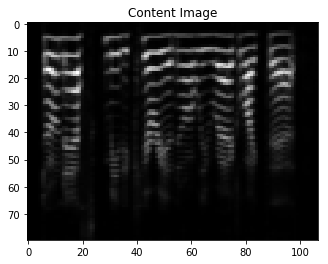

In [15]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [16]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

.. Note::
   **Important detail**: although this module is named ``ContentLoss``, it
   is not a true PyTorch Loss function. If you want to define your content
   loss as a PyTorch Loss function, you have to create a PyTorch autograd function 
   to recompute/implement the gradient manually in the ``backward``
   method.



In [17]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [18]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [19]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [20]:
# cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
# cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

cnn_normalization_mean = torch.tensor([0., 0., 0.]).to(device)
cnn_normalization_std = torch.tensor([1., 1., 1.]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [21]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

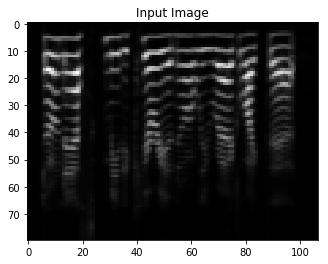

In [22]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [23]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [24]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=10000000000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Finally, we can run the algorithm.




In [25]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 3782174.000000 Content Loss: 2.520493

run [100]:
Style Loss : 1341793.000000 Content Loss: 2.709633

run [150]:
Style Loss : 840254.562500 Content Loss: 2.794587

run [200]:
Style Loss : 617643.375000 Content Loss: 2.874604

run [250]:
Style Loss : 502568.531250 Content Loss: 2.946482

run [300]:
Style Loss : 437133.062500 Content Loss: 2.999714

run [350]:
Style Loss : 384191.343750 Content Loss: 3.046178

run [400]:
Style Loss : 347798.218750 Content Loss: 3.083424

run [450]:
Style Loss : 320782.187500 Content Loss: 3.114832

run [500]:
Style Loss : 298525.218750 Content Loss: 3.142143



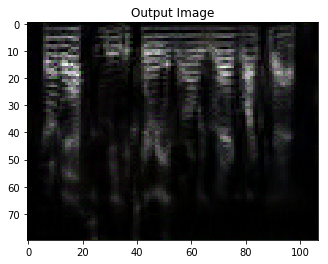

In [26]:
plt.figure()
imshow(output, title='Output Image')

In [29]:
print(output[0][0].shape)
trans_spect = output[0][0].detach().numpy()
trans_spect = trans_spect.T
print(trans_spect.shape)
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

torch.Size([80, 107])
(107, 80)


In [28]:
out_path = "outputs/trans.wav"
trans_audio = run_wavernn(model, trans_spect, out_path, 80)
librosa.output.write_wav(out_path, trans_audio, sr=SAMPLE_RATE)
print("Wrote WAV file:", os.path.abspath(out_path))

Generating samples...
Generated 2.67s in 37.20s (0.072x realtime).
Wrote WAV file: /home/arvindkamal/Desktop/ECE 544/Final Project/gans_audio_style_transfer/Audio Style Transfer/outputs/trans.wav
